## 6. gyakorlat Konvolúciós hálók

A konvolúciós hálók ún. konvolúciós neuronokat tartalmaznak, melyek segítségével hierarchikus lokális jellemzőkinyerést tudunk végrehajtani.
![CNN](https://cdn-images-1.medium.com/max/1200/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg)

In [1]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("Csomagok betöltve.")

# https://www.kaggle.com/raoulma/mnist-image-class-tensorflow-cnn-99-51-test-acc?fbclid=IwAR3u3n-AquYTVvYKj9N1N9XjWX3t_PTCx2c4ILR6G9L2HLo5hvgg-LdZzHU

TensorFlow 1.x selected.
PACKAGES LOADED


# Adatbázis betöltése

In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("MNIST ready")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
MN

### GPU kiválasztása

(otthoni gép esetében)

In [4]:
import os

# define visible gpu device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

tf.set_random_seed(1024)

# CNN háló definiálása

Fontos, hogy a bemenetet reshape-el képpé alakítsuk.

Standard hálósrtuktúra: 
Konvolúció, majd relu
Pooling (maxpooling)

Vizsgáljuk meg a strides értékét, amely meghatározza, hogy a maszkot mennyivel mozgassuk konvolúció ill. pooling során, 
illetve a padding-et amely a széleken határozza meg, hogy a képen kívüli pixelek milyen értéket vegyenek fel.

[Pooling
](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

[Padding (same\valid)](https://aigeekprogrammer.com/wp-content/uploads/2019/12/CNN-valid-vs.-same-1.png)

In [5]:

n_input  = 784
n_output = 10
weights  = {
'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64], stddev=0.1)),
'wd1': tf.Variable(tf.random_normal([14*14*64, n_output], stddev=0.1))
}
biases   = {
'bc1': tf.Variable(tf.random_normal([64], stddev=0.1)),
'bd1': tf.Variable(tf.random_normal([n_output], stddev=0.1))
}
def conv_simple(_input, _w, _b):
# Reshape input
  _input_r = tf.reshape(_input, shape=[-1, 28, 28, 1])
  # Convolution
  _conv1 = tf.nn.conv2d(_input_r, _w['wc1'], strides=[1, 1, 1, 1], padding='SAME')
  # Add-bias
  _conv2 = tf.nn.bias_add(_conv1, _b['bc1'])
  # Pass ReLu
  _conv3 = tf.nn.relu(_conv2)
  # Max-pooling
  _pool  = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
  # Vectorize
  _dense = tf.reshape(_pool, [-1, _w['wd1'].get_shape().as_list()[0]])
  # Fully-connected layer
  _out = tf.add(tf.matmul(_dense, _w['wd1']), _b['bd1'])
  # Return everything
  out = {
      'input_r': _input_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3
      , 'pool': _pool, 'dense': _dense, 'out': _out
  }
  return out
print ("CNN ready")

CNN ready


# Tanítási paraméterek

In [7]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_output])
# Parameters
learning_rate   = 0.001
training_epochs = 10
batch_size      = 100
display_step    = 1
# Functions! 

_pred = conv_simple(x, weights, biases)['out']
#_pred = vgg(x, True)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=_pred, labels=y))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
_corr = tf.equal(tf.argmax(_pred,1), tf.argmax(y,1)) # Count corrects
accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) # Accuracy
init = tf.global_variables_initializer()

print ("Hálózat tanításra kész!")

Hálózat tanításra kész!


# Háló tanítása

Minden epoch után megnézzük, hogy a teszten hogyan teljesít a háló, ez csalás :(

Feladat: csináljunk egy dev halmazt és azon figyeljük a pontosságot, majd csak a tanítás végén nézzük meg a teszt halmazt.


In [8]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

A következő cellát érdemes elindítani, egy ideig fut.

In [11]:
if do_train == 1:
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            summary = sess.run([optm], feed_dict={x: batch_xs, y: batch_ys})
            
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

        # Display logs per epoch step
        if epoch % display_step == 0: 
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
            print (" Training accuracy: %.3f" % (train_acc))
            test_acc = sess.run(accr, feed_dict={x: testimg, y: testlabel})
            print (" Test accuracy: %.3f" % (test_acc))

    print ("Optimization Finished.")

Epoch: 000/010 cost: 0.289892420
 Training accuracy: 0.950
 Test accuracy: 0.967
Epoch: 001/010 cost: 0.100087243
 Training accuracy: 0.950
 Test accuracy: 0.975
Epoch: 002/010 cost: 0.070522399
 Training accuracy: 0.990
 Test accuracy: 0.980
Epoch: 003/010 cost: 0.056018947
 Training accuracy: 0.990
 Test accuracy: 0.981
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Epoch: 004/010 cost: 0.047262542
 Training accuracy: 0.990
 Test accuracy: 0.982
Epoch: 005/010 cost: 0.040304228
 Training accuracy: 0.980
 Test accuracy: 0.983
Epoch: 006/010 cost: 0.035520518
 Training accuracy: 0.990
 Test accuracy: 0.980
Epoch: 007/010 cost: 0.031013607
 Training accuracy: 1.000
 Test accuracy: 0.984
Epoch: 008/010 cost: 0.027578182
 Training accuracy: 0.990
 Test accuracy: 0.983
Epoch: 009/010 cost: 0.024646148
 Training accuracy: 0.990
 Test accuracy: 0.981
Optimization Finished.


## Vizsgáljuk meg a CNN háló belsejét!

In [13]:
conv_out = conv_simple(x, weights, biases)

input_r = sess.run(conv_out['input_r'], feed_dict={x: trainimg[0:1, :]})
conv1   = sess.run(conv_out['conv1'], feed_dict={x: trainimg[0:1, :]})
conv2   = sess.run(conv_out['conv2'], feed_dict={x: trainimg[0:1, :]})
conv3   = sess.run(conv_out['conv3'], feed_dict={x: trainimg[0:1, :]})
pool    = sess.run(conv_out['pool'], feed_dict={x: trainimg[0:1, :]})
dense   = sess.run(conv_out['dense'], feed_dict={x: trainimg[0:1, :]})
out     = sess.run(conv_out['out'], feed_dict={x: trainimg[0:1, :]})

# Input

Size of 'input_r' is (1, 28, 28, 1)
Label is 7


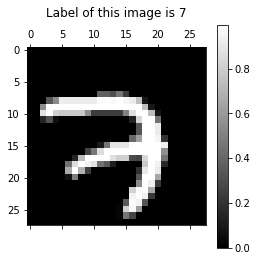

In [15]:
# Let's see 'input_r'
print ("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(trainlabel[0, :])
print ("Label is %d" % (label))

# Plot ! 
plt.matshow(input_r[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label) + "\n")
plt.colorbar()
plt.show()

# Conv1 (1. rejtett réteg)

Size of 'conv1' is (1, 28, 28, 64)


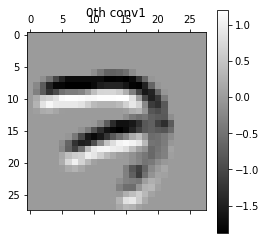

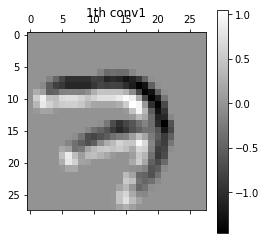

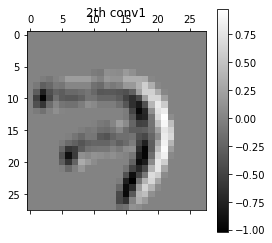

In [16]:
# Let's see 'conv1'
print ("Size of 'conv1' is %s" % (conv1.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv1")
    plt.colorbar()
    plt.show() 

# Conv2 (+bias)

Size of 'conv2' is (1, 28, 28, 64)


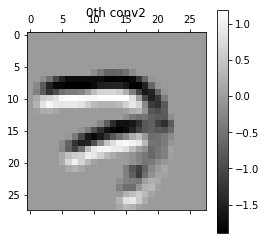

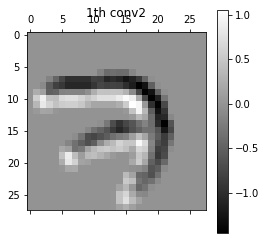

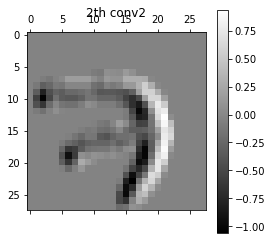

In [17]:
# Let's see 'conv2'
print ("Size of 'conv2' is %s" % (conv2.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv2[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv2")
    plt.colorbar()
    plt.show() 

# Conv3 (+ReLU)

Size of 'conv3' is (1, 28, 28, 64)


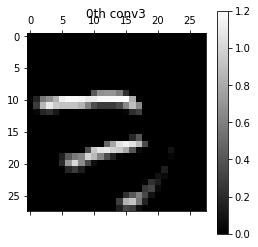

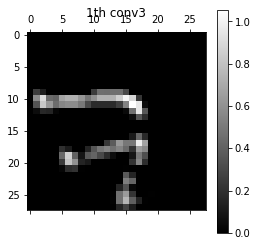

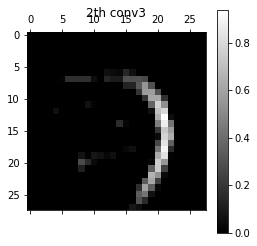

In [18]:
# Let's see 'conv3'
print ("Size of 'conv3' is %s" % (conv3.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv3[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv3")
    plt.colorbar()
    plt.show() 

# Pooling (max_pool)

Size of 'pool' is (1, 14, 14, 64)


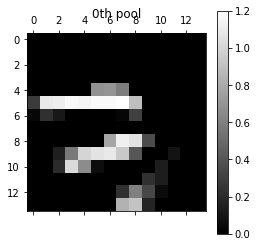

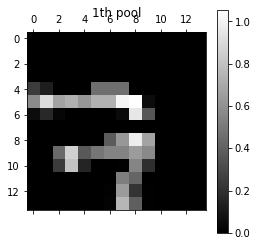

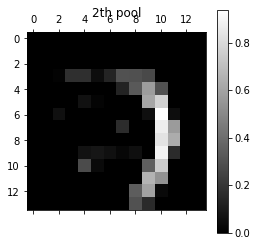

In [19]:
# Let's see 'pool'
print ("Size of 'pool' is %s" % (pool.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(pool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th pool")
    plt.colorbar()
    plt.show() 

# Fully connected réteg

In [20]:
# Let's see 'dense'
print ("Size of 'dense' is %s" % (dense.shape,))
# Let's see 'out'
print ("Size of 'out' is %s" % (out.shape,))

Size of 'dense' is (1, 12544)
Size of 'out' is (1, 10)


# Konvolúciós filterek

Size of 'wc1' is (3, 3, 1, 64)


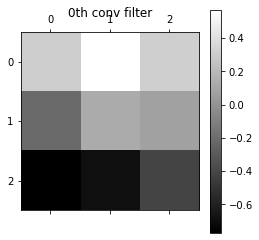

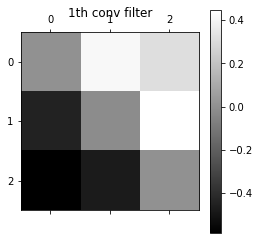

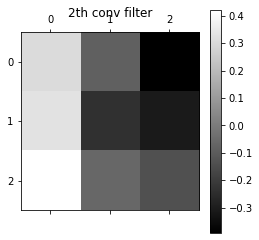

In [21]:
# Let's see weight! 
wc1 = sess.run(weights['wc1'])
print ("Size of 'wc1' is %s" % (wc1.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(wc1[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
    plt.show() 

# Feladatok
1. Validációs halmaz használata.
2. Bonyolultabb struktúra pl VGG struktúra használata.
3. Data augmentáció: tanító képeken forgatás, eltolás alkalmazása.



# Keras CNN MNIST

Forrás:

https://keras.io/examples/mnist_cnn/


In [2]:
from tensorflow import keras
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [ ]:
x_train.shape

(60000, 28, 28)

In [3]:

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':  # ?x28x28x1  ?x1x28x28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
 1664/60000 [..............................] - ETA: 2:30 - loss: 1.8403 - accuracy: 0.3750

KeyboardInterrupt: ignored